# Data Cleaning 


## Objectives 


- Improve data quality
- Handle missing data 

## Inputs

- outputs/datasets/datacollection/HousePrices.csv

# Outputs

- Train Set
- Test Set


## CRISP-DM 


"Data Preparation"

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues'

In [4]:
# Load data 

import pandas as pd
df = pd.read_csv("outputs/datasets/datacollection/HousePrices.csv")
df.head(10)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000
5,796,566.0,1.0,No,732,GLQ,64,NaN,480,Unf,...,85.0,0.0,30,5,5,796,NaN,1993,1995,143000
6,1694,0.0,3.0,Av,1369,GLQ,317,NaN,636,RFn,...,75.0,186.0,57,5,8,1686,NaN,2004,2005,307000
7,1107,983.0,3.0,Mn,859,ALQ,216,NaN,484,NaN,...,NaN,240.0,204,6,7,1107,NaN,1973,1973,200000
8,1022,752.0,2.0,No,0,Unf,952,NaN,468,Unf,...,51.0,0.0,0,5,7,952,NaN,1931,1950,129900
9,1077,0.0,2.0,No,851,GLQ,140,NaN,205,RFn,...,50.0,0.0,4,6,5,991,NaN,1939,1950,118000


In [5]:
# Variables with missing data. 

vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

In [6]:
df.loc[:, vars_with_missing_data].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   2ndFlrSF       1374 non-null   float64
 1   BedroomAbvGr   1361 non-null   float64
 2   BsmtFinType1   1346 non-null   object 
 3   EnclosedPorch  136 non-null    float64
 4   GarageFinish   1298 non-null   object 
 5   GarageYrBlt    1379 non-null   float64
 6   LotFrontage    1201 non-null   float64
 7   MasVnrArea     1452 non-null   float64
 8   WoodDeckSF     155 non-null    float64
dtypes: float64(7), object(2)
memory usage: 102.8+ KB


In [7]:
# Code can be found in the Churnometer Data Cleaning workbook.
from pandas_profiling import ProfileReport
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

/tmp/ipykernel_1215/810454577.py:2: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps 

# Use inline plotting for Jupyter
%matplotlib inline

def plot_heatmap(matrix, threshold, figsize=(20, 12), font_size=8, cmap="viridis", mask_upper=True):
    if matrix.shape[1] > 1:
        mask = np.zeros_like(matrix, dtype=bool)

        if mask_upper:
            mask[np.triu_indices_from(mask)] = True

        mask[abs(matrix) < threshold] = True

        plt.figure(figsize=figsize)
        sns.heatmap(matrix, annot=True, mask=mask, cmap=cmap, annot_kws={"size": font_size},
                    linewidths=0.5, linecolor="gray")
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.ylim(len(matrix.columns), 0)
        plt.show()

def compute_correlation_and_pps(df):
    spearman_corr = df.corr(method="spearman")
    pearson_corr = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.pivot(index="y", columns="x", values="ppscore")

    pps_stats = pps_matrix_raw.query("ppscore < 1 ")["ppscore"].describe()
    print("PPS Summary Stats (for threshold selection):\n", pps_stats.round(3))

    return pearson_corr, spearman_corr, pps_matrix

def display_heatmaps(pearson_corr, spearman_corr, pps_matrix, corr_threshold, pps_threshold, figsize=(20,12), font_size=8):
    print("Spearman Correlation Heatmap (Montonic relationships):")
    plot_heatmap(pearson_corr, corr_threshold, figsize, font_size, cmap="magma")

    print("Pearson Correlation Heatmap (Linear relationships):")
    plot_heatmap(pearson_corr, corr_threshold, figsize, font_size, cmap="coolwarm")

    print("Power Predictive Score (PPS) Heatmap:")
    plot_heatmap(pps_matrix, pps_threshold, figsize, font_size, cmap="rocket_r", mask_upper=False)


/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  

PPS Summary Stats (for threshold selection):
 count    552.000
mean       0.055
std        0.104
min        0.000
25%        0.000
50%        0.000
75%        0.066
max        0.702
Name: ppscore, dtype: float64
Spearman Correlation Heatmap (Montonic relationships):


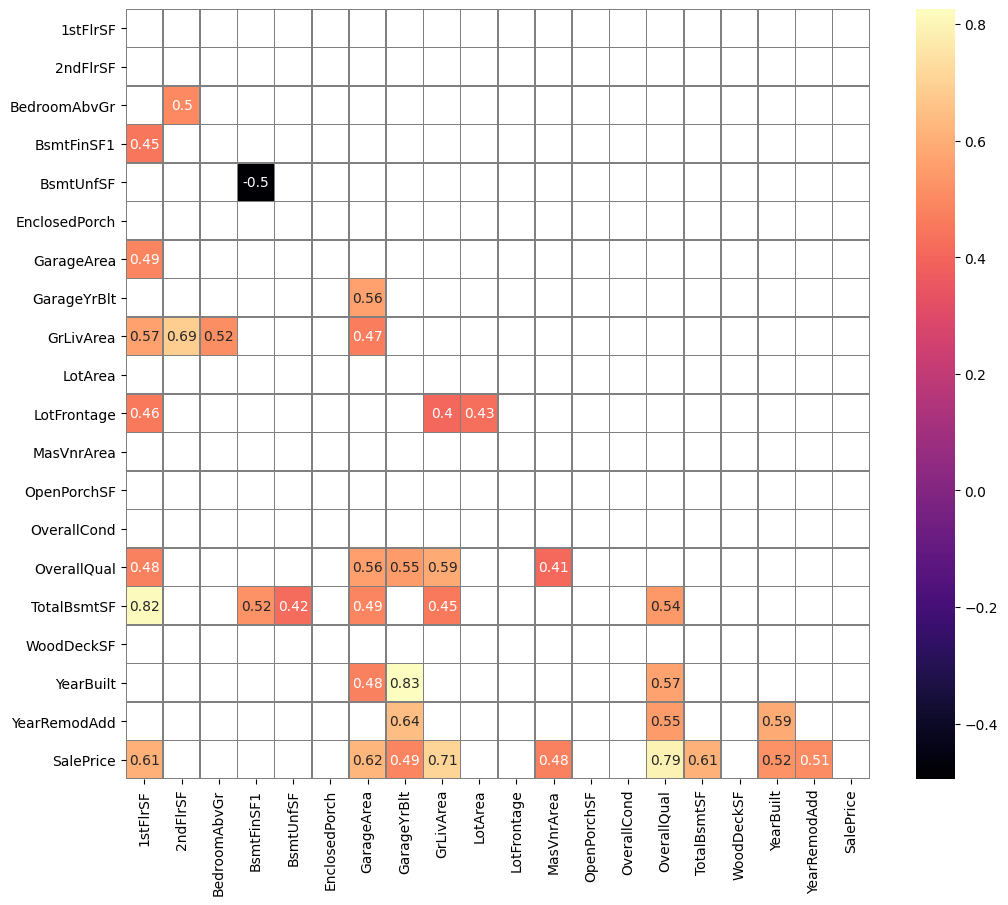

Pearson Correlation Heatmap (Linear relationships):


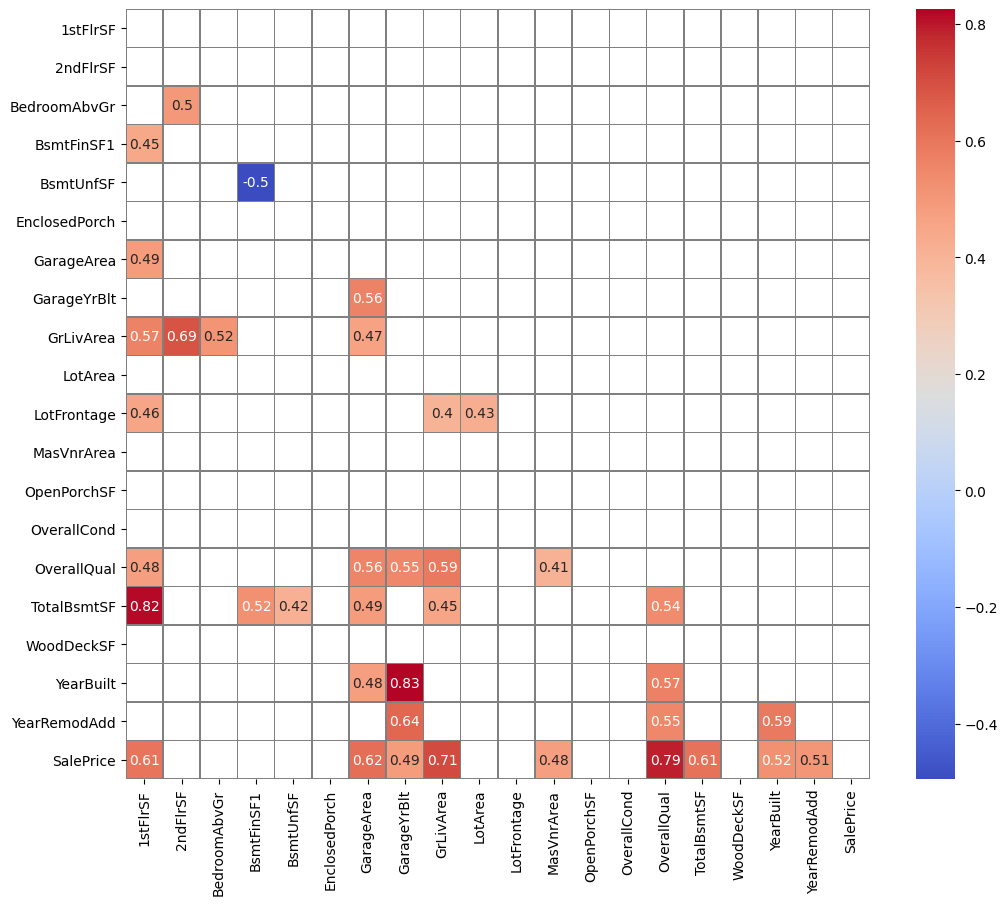

Power Predictive Score (PPS) Heatmap:


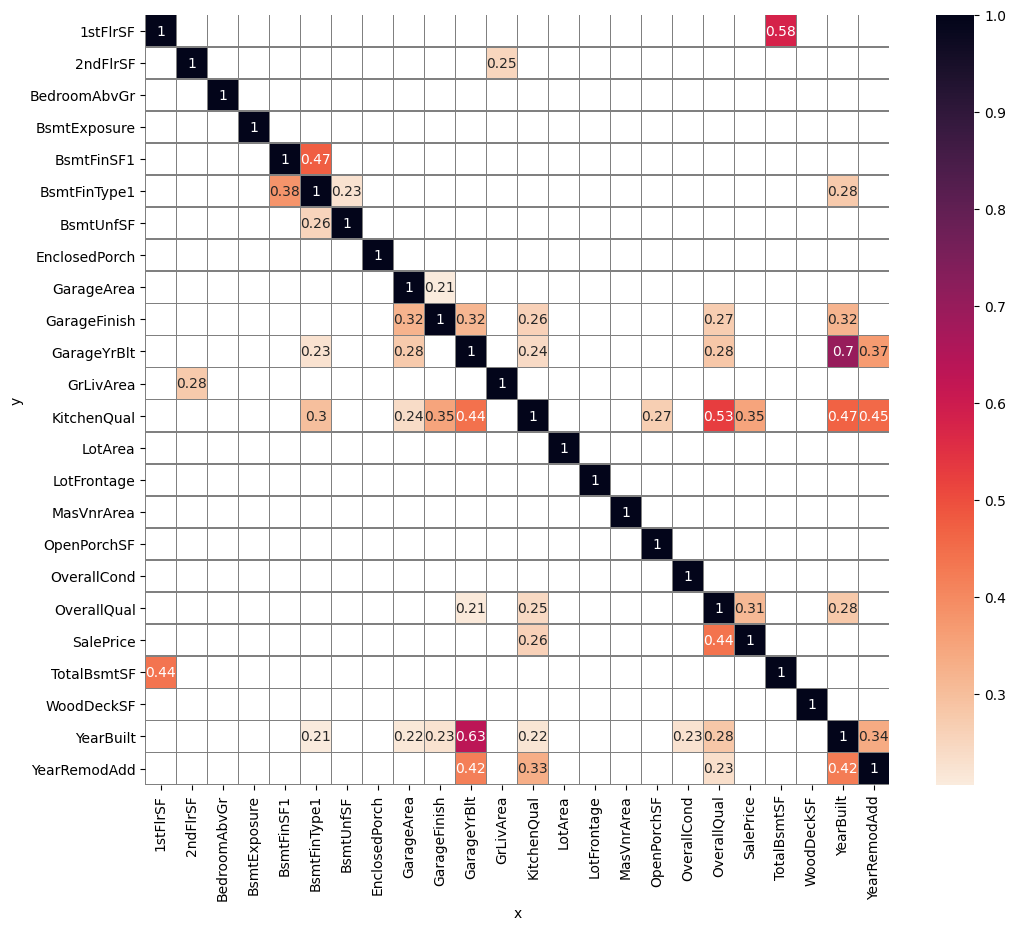

In [9]:
df_corr_pearson, df_corr_spearman, pps_matrix = compute_correlation_and_pps(df)

display_heatmaps(
    pearson_corr=df_corr_pearson, 
    spearman_corr=df_corr_spearman, 
    pps_matrix=pps_matrix, 
    corr_threshold=0.4, 
    pps_threshold=0.2, 
    figsize=(12, 10), 
    font_size=10
)


In [10]:
def evaluate_missing_data(df):
    """
    Analyse variables with missing values
    """
    missing_counts = df.isnull().sum()
    missing_percentage = (missing_counts / df.shape[0] * 100).round(2)
    

    # Create a DataFrame to hold the missing data statistics. 
    missing_data_df = pd.DataFrame({
        "RowsWithMissingData": missing_counts,
        "PercentageOfDataset": missing_percentage,
        "DataType": df.dtypes
    })

    # Filter to include only columns with missing data and sort.
    missing_data_df = missing_data_df[missing_data_df["PercentageOfDataset"] > 0]
    missing_data_df = missing_data_df.sort_values(by="PercentageOfDataset", ascending=False)

    return missing_data_df

In [11]:
evaluate_missing_data(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


- "EnclosedPorch" and "WoodDeckSF" have the most missing values at well over 80% each. I would deem these variables almost obsolete as they don't offer much in the way of predcting house prices. 

In [12]:
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

sns.set_theme(style="ticks")

def visualize_cleaning_impact(original_df, cleaned_df, vars_with_missing_data):
    """
    Function to visualize the impact of data cleaning on selected variables.
    """

    plot_index = 1 

    # Identifying categorical and numerical columns
    cat_vars = original_df.select_dtypes(include=["object", "category"]).columns
    num_vars = original_df.select_dtypes(include=["number"]).columns

    # Loop through variables selected for analysis
    print("Analysis of distribution changes after data cleaning :\n")

    for var in vars_with_missing_data:

        if var in cat_vars: 
            data_original = pd.DataFrame({"Dataset": "Original", var: original_df[var]})
            data_cleaned = pd.DataFrame({"Dataset": "Cleaned", var: cleaned_df[var]})
            merged_data = pd.concat([data_original, data_cleaned], axis=0)

            plt.figure(figsize=(10, 5))
            sns.countplot(data=merged_data, x=var, hue="Dataset", palette=["#8EF9F3", "#564787"])
            plt.title(f"Bar Plot {plot_index}: {var}")
            plt.xticks(rotation=8)
            plt.legend(loc="upper right")
            plt.tight_layout()
            plt.show()

        elif var in num_vars:
            plt.figure(figsize=(10, 5))
            sns.histplot(original_df[var], color="#8EF9F3", label="Original", kde=True, elements="step")
            sns.histplot(cleaned_df[var], color="#564787", label="cleaned", kde=True, element="step")
            plt.title(f"Histogram {plot_index}: {var}")
            plt.legend(loc="upper right")
            plt.tight_layout()
            plt.show()

        plot_index += 1


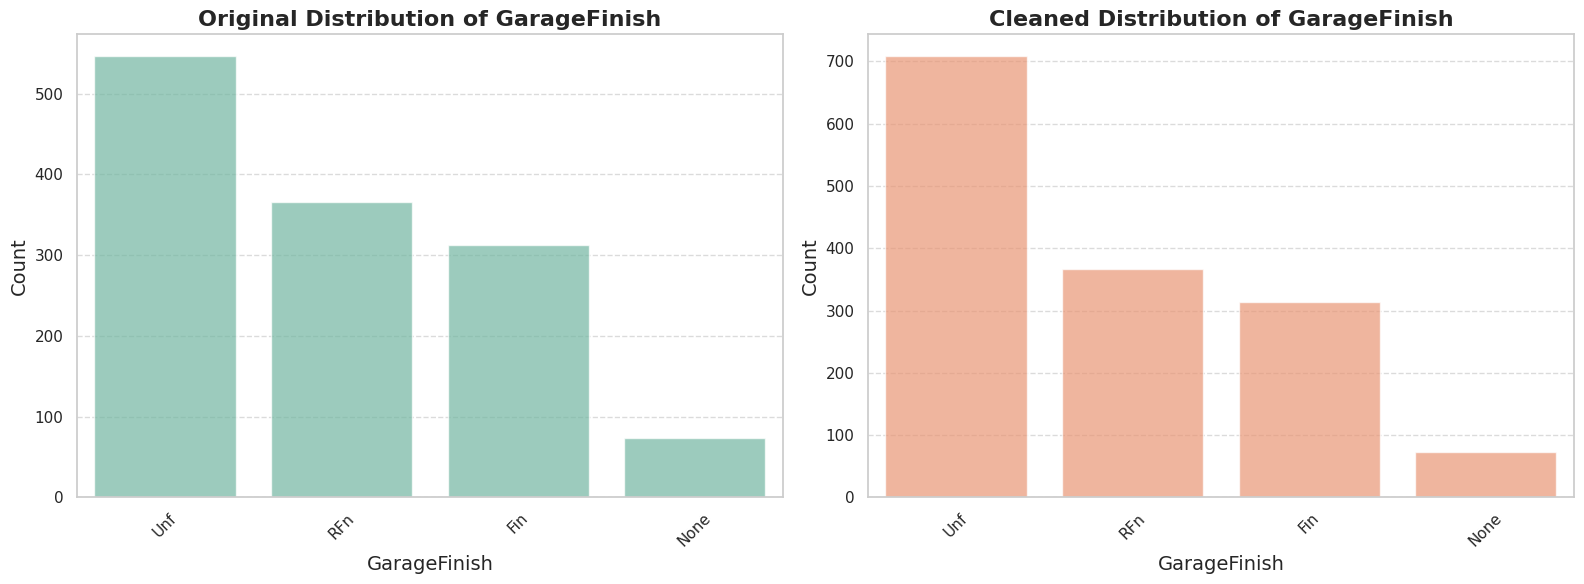

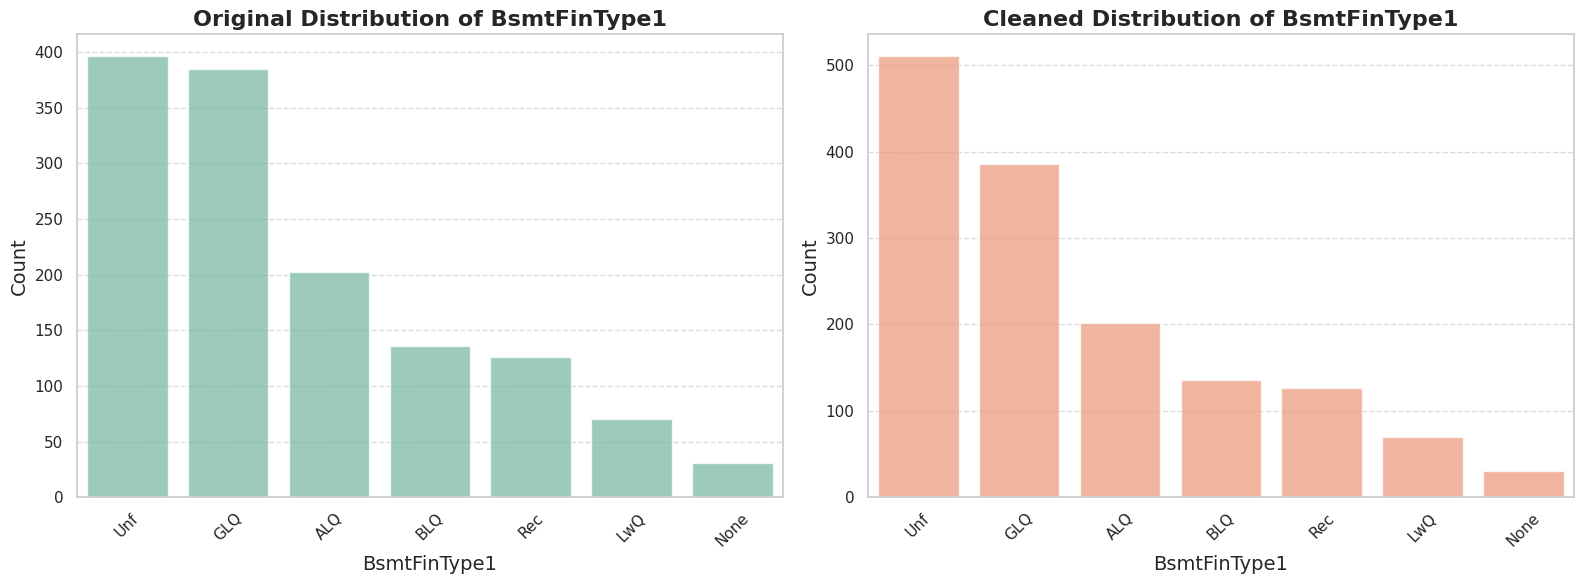

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

# Select variables to apply the method to
variables_method = ['GarageFinish', 'BsmtFinType1']

# Initialize the SimpleImputer with a strategy
imputer = SimpleImputer(strategy='constant', fill_value='Unf')

# Fit and transform the data
df_method = df.copy()
df_method[variables_method] = imputer.fit_transform(df[variables_method])

# Function to plot the distribution of a variable side-by-side
def plot_distribution(original, cleaned, variable):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Set a color palette
    palette = sns.color_palette("Set2")

    # Plot original distribution on the first subplot
    sns.countplot(data=original, x=variable, color=palette[0], alpha=0.7, order=original[variable].value_counts().index, ax=axes[0])
    axes[0].set_title(f'Original Distribution of {variable}', fontsize=16, fontweight='bold')
    axes[0].set_xlabel(variable, fontsize=14)
    axes[0].set_ylabel('Count', fontsize=14)
    axes[0].tick_params(axis='x', labelrotation=45)
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot cleaned distribution on the second subplot
    sns.countplot(data=cleaned, x=variable, color=palette[1], alpha=0.7, order=cleaned[variable].value_counts().index, ax=axes[1])
    axes[1].set_title(f'Cleaned Distribution of {variable}', fontsize=16, fontweight='bold')
    axes[1].set_xlabel(variable, fontsize=14)
    axes[1].set_ylabel('Count', fontsize=14)
    axes[1].tick_params(axis='x', labelrotation=45)
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# Plot the distribution for each variable before and after imputation
for var in variables_method:
    plot_distribution(df, df_method, var)


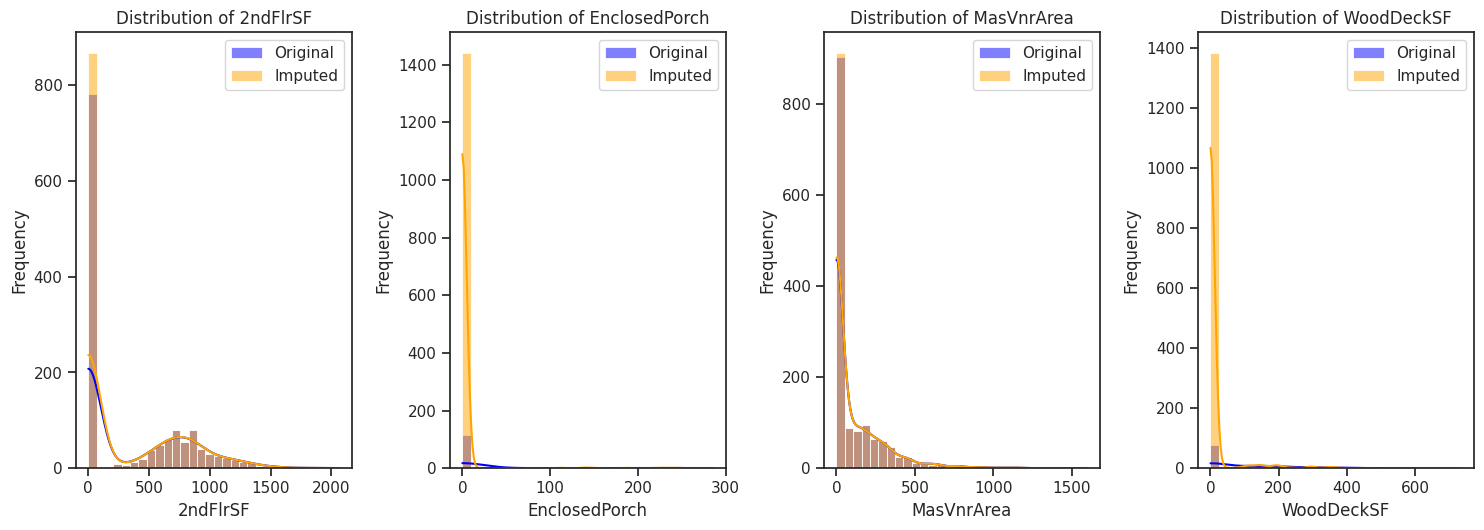

In [13]:
# "2ndFlrSF", "EnclosedPorch", "MasVnrArea"m, "WoodDeckSF"

from feature_engine.imputation import ArbitraryNumberImputer

# Function to plot distributions before and after imputation
def plot_variable_distribution(df_original, df_cleaned, variables):
    plt.figure(figsize=(15, 10))

    for i, variable in enumerate(variables):
        plt.subplot(2, len(variables), i + 1)
        sns.histplot(df_original[variable], bins=30, kde=True, color='blue', label='Original', alpha=0.5)
        sns.histplot(df_cleaned[variable], bins=30, kde=True, color='orange', label='Imputed', alpha=0.5)
        plt.title(f'Distribution of {variable}')
        plt.xlabel(variable)
        plt.ylabel('Frequency')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Select an imputation method
imputer = ArbitraryNumberImputer(arbitrary_number=0, variables=['2ndFlrSF', 'EnclosedPorch', 'MasVnrArea', 'WoodDeckSF'])

# Create a DataFrame to apply the method
df_method = imputer.fit_transform(df)

# Assess the effect on the variable distribution
plot_variable_distribution(df_original=df, df_cleaned=df_method, variables=['2ndFlrSF', 'EnclosedPorch', 'MasVnrArea', 'WoodDeckSF'])


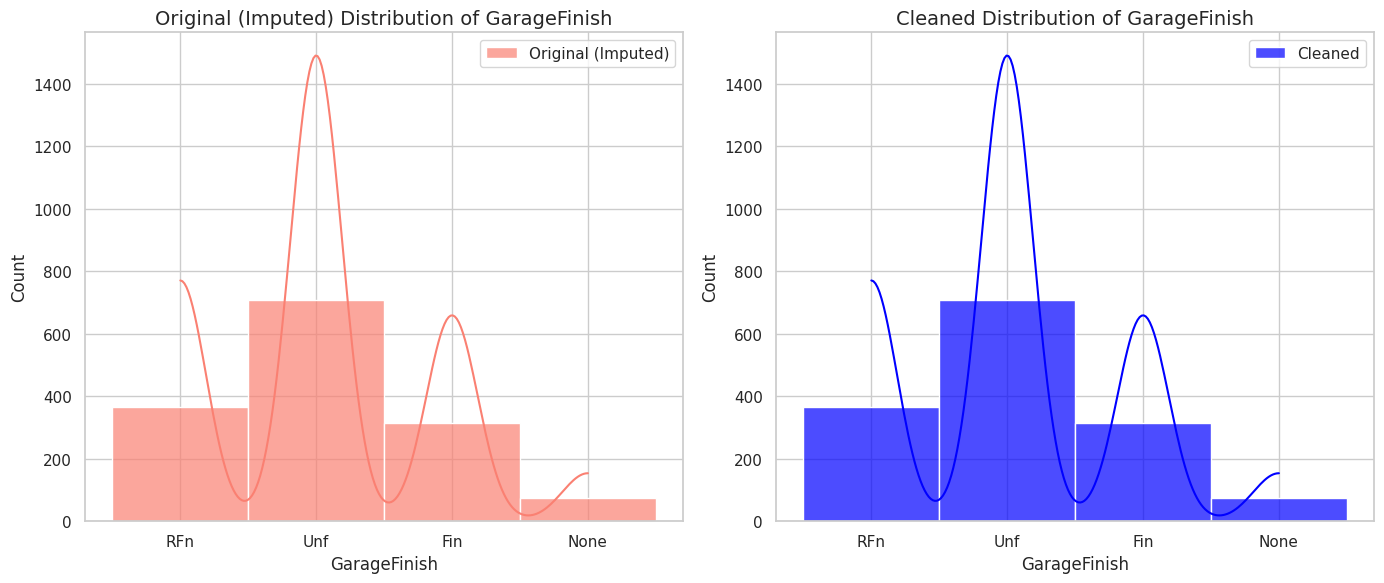

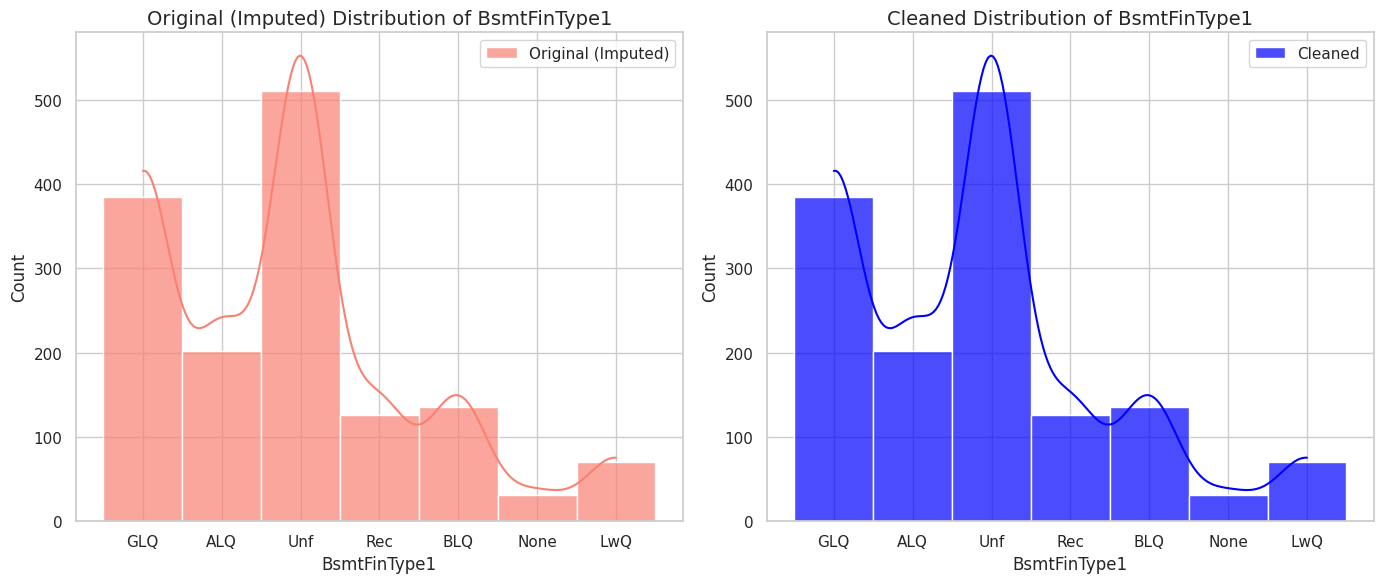

In [31]:
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

def DataCleaningEffect(df_original, df_cleaned, variables_applied_with_method, impute_strategy="mean"):
    # Separate numeric and non-numeric columns
    numeric_vars = df_original[variables_applied_with_method].select_dtypes(include='number').columns
    non_numeric_vars = df_original[variables_applied_with_method].select_dtypes(exclude='number').columns

    df_original_imputed = df_original.copy()
    
    # Apply imputation on numeric columns using the mean strategy
    if len(numeric_vars) > 0:
        numeric_imputer = SimpleImputer(strategy="mean")
        df_original_imputed[numeric_vars] = numeric_imputer.fit_transform(df_original[numeric_vars])

    # Apply imputation on non-numeric columns using the most frequent strategy
    if len(non_numeric_vars) > 0:
        non_numeric_imputer = SimpleImputer(strategy="most_frequent")
        df_original_imputed[non_numeric_vars] = non_numeric_imputer.fit_transform(df_original[non_numeric_vars])

    # Visualization part
    for var in variables_applied_with_method:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

        # Plot the original (imputed) data with histogram and KDE on the first subplot
        sns.histplot(df_original_imputed[var], kde=True, color="salmon", bins=30, label="Original (Imputed)", alpha=0.7, ax=axes[0])
        axes[0].set_title(f"Original (Imputed) Distribution of {var}", fontsize=14)
        axes[0].set_xlabel(var, fontsize=12)
        axes[0].set_ylabel("Count", fontsize=12)
        axes[0].legend(loc="upper right")

        # Plot the cleaned data with histogram and KDE on the second subplot
        sns.histplot(df_cleaned[var], kde=True, color="blue", bins=30, label="Cleaned", alpha=0.7, ax=axes[1])
        axes[1].set_title(f"Cleaned Distribution of {var}", fontsize=14)
        axes[1].set_xlabel(var, fontsize=12)
        axes[1].set_ylabel("Count", fontsize=12)
        axes[1].legend(loc="upper right")

        # Add grid for better readability
        axes[0].grid(True)
        axes[1].grid(True)

        plt.tight_layout()
        plt.show()

# Example of how you'd call it
DataCleaningEffect(df_original=df, 
                   df_cleaned=df_method, 
                   variables_applied_with_method=variables_method)


In [71]:
# Shuffle the DataFrame
shuffled_df = df.sample(frac=1, random_state=0).reset_index(drop=True)

# Calculate the index for splitting
split_index = int(0.8 * len(shuffled_df))

# Create the training and testing sets
TrainSet = shuffled_df.iloc[:split_index]
TestSet = shuffled_df.iloc[split_index:]

# Get the SalePrice column
y_train = TrainSet["SalePrice"]
y_test = TestSet["SalePrice"]

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (1168, 24) 
TestSet shape: (292, 24)
